# TP : apprentissage multimodal


Dans ce TP, nous allons utiliser le modèle d'apprentissage, FashionCLIP, pré-entraîné sur des images ainsi que des descriptions en langage naturel. Plus particulièrement, nous allons considérer deux cas d'usage :

*   **Moteur de recherche d'images :** il s'agit de trouver, à partir d'une requête en langage naturel, l'image correspondante.

*   **Classification zero-shot :** il s'agit simplement de construire un classifieur d'images (faire correspondre un label à une image).



## Dataset

Nous allons dans un premier temps télécharger les données. Celles-ci provienennt de [Kaggle](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations).

In [1]:
# %%capture
# !pip install gdown
# !gdown "1igAuIEW_4h_51BG1o05WS0Q0-Cp17_-t&confirm=t"
# !unzip data

### Modèle FashionCLIP

Nous allons également télécharger le modèle pré-entraîné.

In [2]:
# %%capture
# !pip install -U fashion-clip

In [3]:
import sys
#sys.path.append("fashion-clip/")
from fashion_clip.fashion_clip import FashionCLIP
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression

2023-11-11 16:30:56.924330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-11 16:30:57.604655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
%%capture
fclip = FashionCLIP('fashion-clip')

FashionCLIP, à l'instar de CLIP, crée un espace vectoriel partagé pour les images et le texte. Cela permet de nombreuses applications, telles que la recherche (trouver l'image la plus similaire à une requête donnée) ou la classification zero-shot.

Il y a principalement deux composants : un encodeur d'image (pour générer un vecteur à partir d'une image) et un encodeur de texte (pour générer un vecteur à partir d'un texte).










<img src="https://miro.medium.com/v2/resize:fit:1400/0*FLNMtW6jK51fm7Og"  width="400">



Nous allons télécharger les données que nous allons ensuite nettoyer.

In [5]:
articles = pd.read_csv("data_for_fashion_clip/articles.csv")

# Supprimer les éléments ayant la même description
subset = articles.drop_duplicates("detail_desc").copy()

# Supprimer les images dont la catégorie n'est pas renseignée
subset = subset[~subset["product_group_name"].isin(["Unknown"])]

# Garder seulement les descriptions dont la longueur est inférieure à 40 tokens
subset = subset[subset["detail_desc"].apply(lambda x : 4 < len(str(x).split()) < 40)]

# Supprimer les articles qui ne sont pas suffisamment fréquents dans le jeu de données
most_frequent_product_types = [k for k, v in dict(Counter(subset["product_type_name"].tolist())).items() if v > 10]
subset = subset[subset["product_type_name"].isin(most_frequent_product_types)]

subset.head(3)

article_id  product_code                   prod_name  product_type_no  \
0   108775044        108775                   Strap top              253   
1   176754003        176754  2 Row Braided Headband (1)               74   
3   189634031        189634           Long Leg Leggings              273   

  product_type_name  product_group_name  graphical_appearance_no  \
0          Vest top  Garment Upper body                  1010016   
1   Hair/alice band         Accessories                  1010016   
3   Leggings/Tights  Garment Lower body                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...  \
0                     Solid                 10             White  ...   
1                     Solid                 17   Yellowish Brown  ...   
3                     Solid                 93        Dark Green  ...   

    department_name index_code          index_name index_group_no  \
0      Jersey Basic          A          Ladieswear              1   
1  Hair Accessories          C  Ladies Accessories              1   
3           Basic 1          D             Divided              2   

   index_group_name section_no              section_name garment_group_no  \
0        Ladieswear         16    Womens Everyday Basics             1002   
1        Ladieswear         66  Womens Small accessories             1019   
3           Divided         51            Divided Basics             1002   

   garment_group_name                                        detail_desc  
0        Jersey Basic            Jersey top with narrow shoulder straps.  
1         Accessories  Two-strand hairband with braids in imitation s...  
3        Jersey Basic  Leggings in stretch jersey with an elasticated...  

[3 rows x 25 columns]

In [6]:
subset.to_csv("subset_data.csv", index=False)
f"Il y a {len(subset)} éléments dans le dataset"

'Il y a 3104 éléments dans le dataset'

## Moteur de recherche d'images

Constuire un moteur de recherche qui permet, à partir d'une description en langage naturel, de récupérer l'image correspondante. Mesurer ses performances (précision).

<img src="https://miro.medium.com/v2/resize:fit:1400/1*cnKHgLAumVyuHuK9pkqr7A.gif"  width="800">


In [18]:
images = ["data_for_fashion_clip/" + str(k) + ".jpg" for k in subset["article_id"].tolist()]
texts = subset["detail_desc"].tolist()

# Créer les représentations vectorielles (embeddings) des images et des descriptions.
image_embeddings = fclip.encode_images(images, batch_size=32)
text_embeddings = fclip.encode_text(texts, batch_size=32)

100%|██████████| 97/97 [01:46<00:00,  1.10s/it]


Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

100%|██████████| 97/97 [00:09<00:00,  9.76it/s]


In [19]:
print(image_embeddings.shape)
print(text_embeddings.shape)

(3104, 512)
(3104, 512)


In [20]:
# Fonction pour récupérer l'image correspondante à partir de la description en langage naturel
def search_image_by_desc(queries, text_embeddings, images):
    # Encodage de la requête en langage naturel
    query_embedding = fclip.encode_text(queries, batch_size=32)[0]

    # Calcul de la similarité cosinus entre la requête et les embeddings textuels
    similarities = np.dot(text_embeddings, query_embedding)

    # Trouver l'indice de l'embedding texte le plus similaire
    most_similar_index = np.argmax(similarities)
    print(f"Most similar index: {most_similar_index}")

    # Récupérer l'image correspondante
    corresponding_image = images[most_similar_index]

    return corresponding_image

Jersey top with narrow shoulder straps.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 109.77it/s]

(3104,) (3104, 512) (512,)
Most similar index: 0


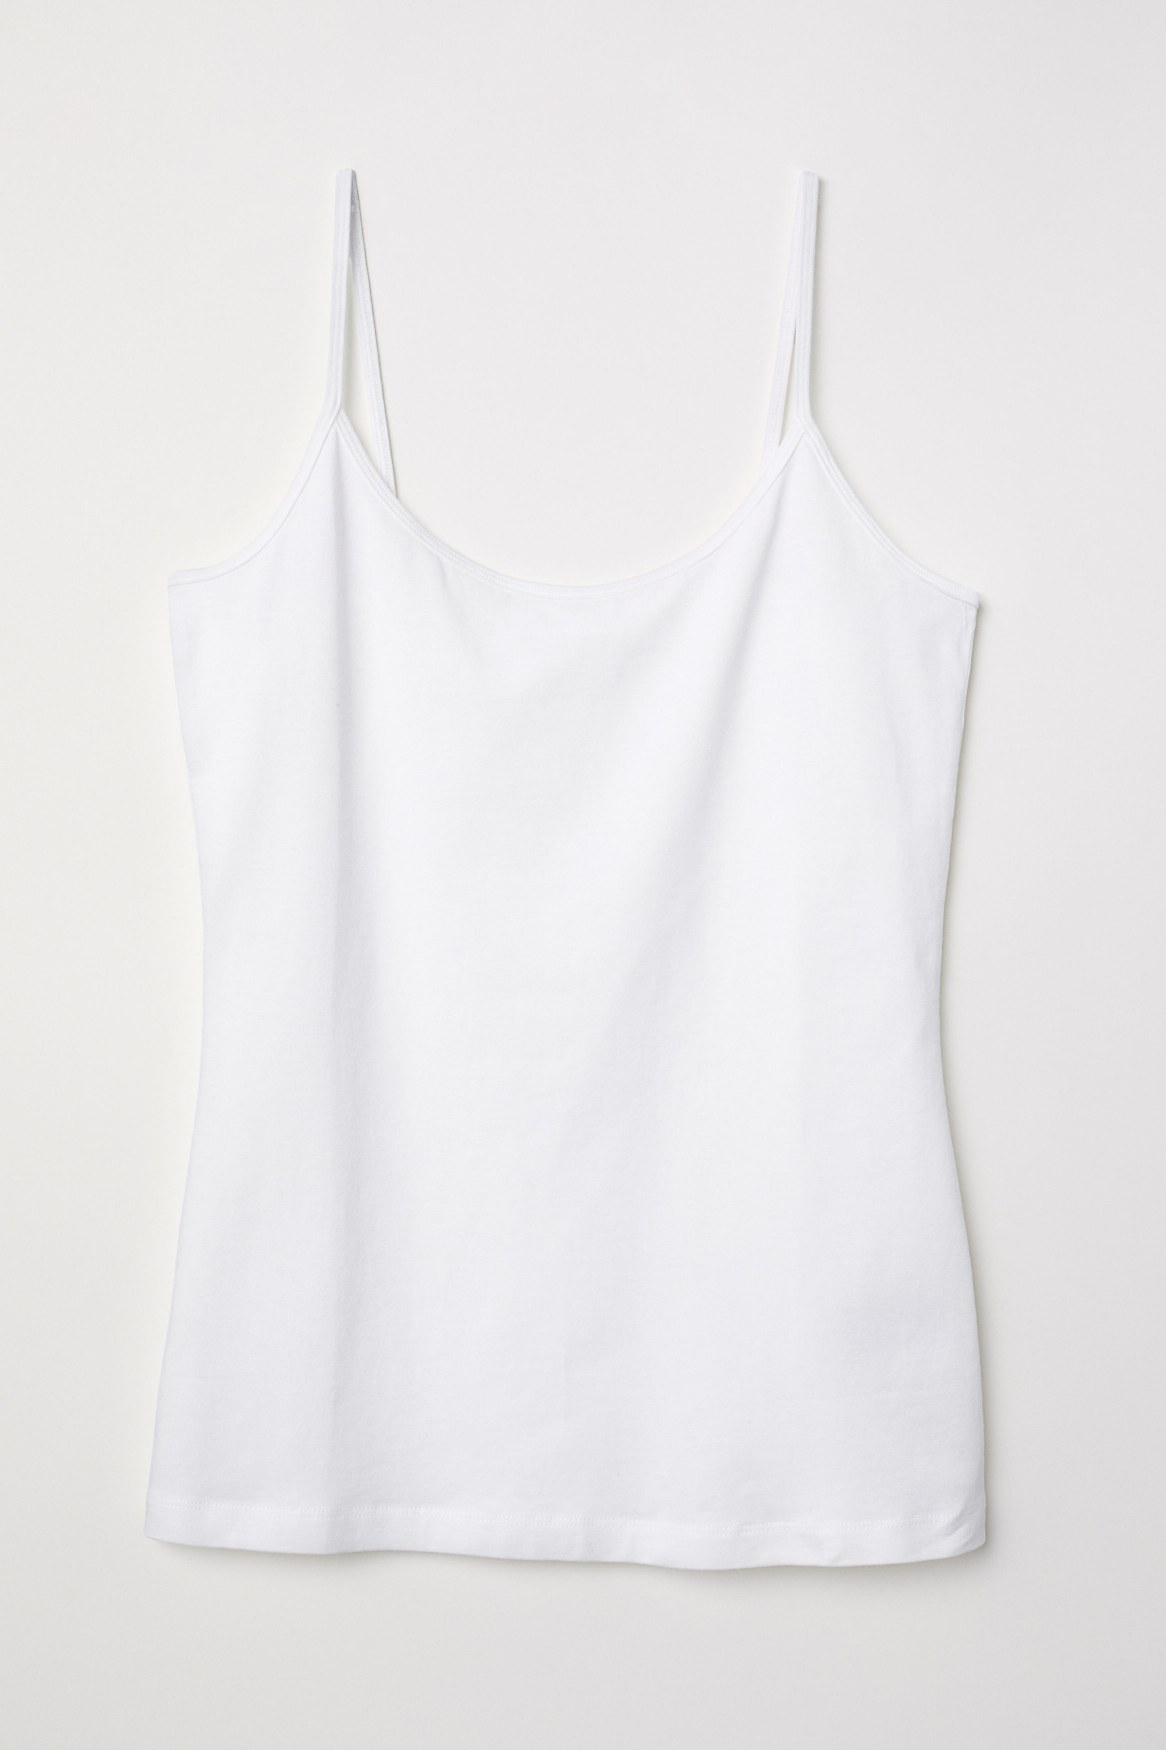

In [21]:
from IPython.display import Image, display

query = subset.iloc[0]['detail_desc']
print(query)
corresponding_image = search_image_by_desc([query], text_embeddings, images)
display(Image(corresponding_image, width=300, height=200))

Leggings in stretch jersey with an elasticated waist.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 118.79it/s]

(3104,) (3104, 512) (512,)
Most similar index: 2394


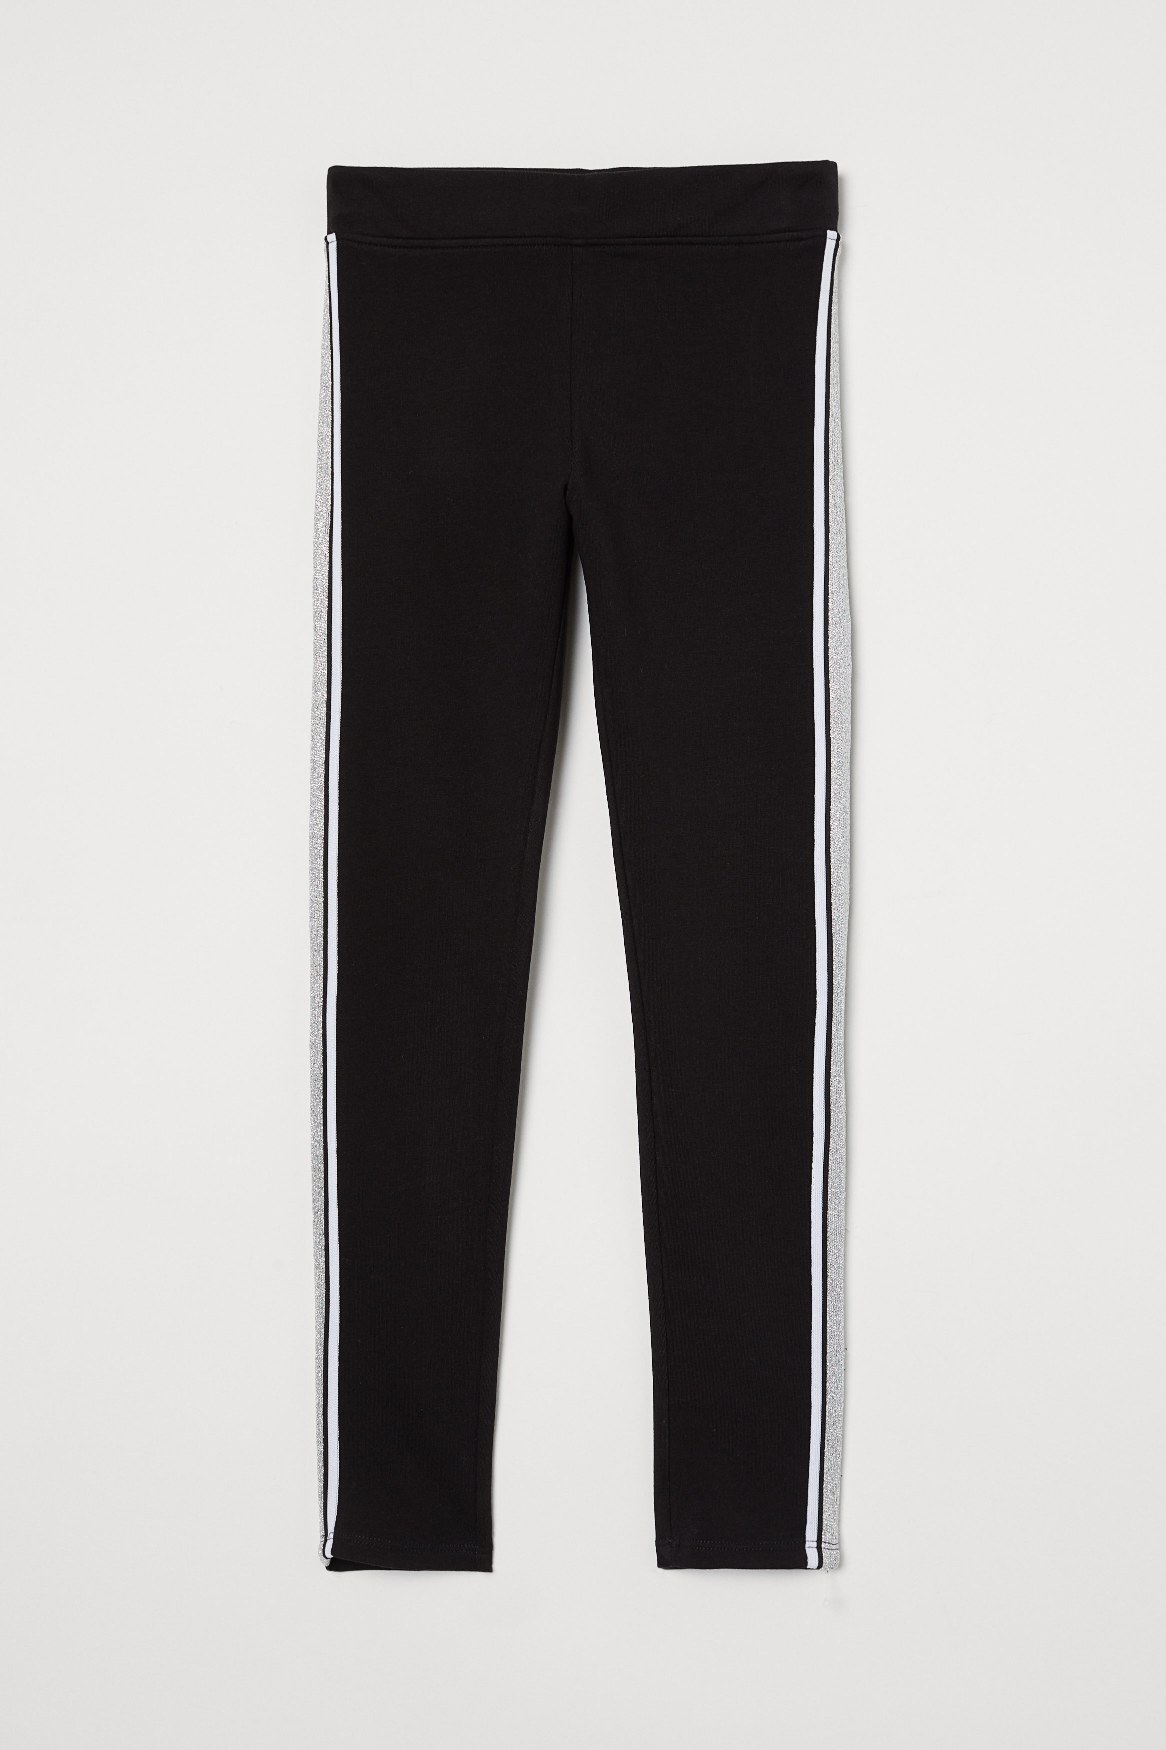

Here the wrong image is found


In [22]:
query = subset.iloc[2]['detail_desc']
print(query)
corresponding_image = search_image_by_desc([query], text_embeddings, images)
display(Image(corresponding_image, width=300, height=200))
print('Here the wrong image is found')

N.B: Ne pas préciser la couleur de l'article ça ne sert à rien pour query.  
Regardons la précision du moteur de recherche en reprenant les descriptions embeddings.

In [13]:
# Let's get the precision of the text_embeddings with itself     
similarities = np.dot(text_embeddings, text_embeddings.T)

# Trouver les indices des embeddings texte les plus similaires
most_similar_indices = np.argmax(similarities, axis=0)

# Top-1 precision
top1_precision = np.mean(most_similar_indices == np.arange(len(text_embeddings)))
print(f"Top-1 precision: {top1_precision}")


# Top-5 precision 
five_most_similar_indices = np.argsort(similarities, axis=0)[-5:].T

top5_precision = np.mean([i in five_most_similar_indices[i] for i in range(len(text_embeddings))])
print(f"Top-5 precision: {top5_precision}")

Top-1 precision: 0.8414948453608248
Top-5 precision: 0.9800257731958762


# Classification zero-shot  

La classification zéro shot (zero-shot classification en anglais) fait référence à un type de tâche d'apprentissage automatique où un modèle est capable de classer des exemples qui n'ont pas été inclus dans l'ensemble d'entraînement initial. En d'autres termes, le modèle doit effectuer une classification sur des données qu'il n'a jamais vues auparavant.  

Construite un classsifieur d'images (prédire le label d'une image). Mesurer ses performances.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*No6ZONpQMIcfFaNMOI5oNw.gif"  width="800">



In [14]:
def search_desc_by_image(images, image_embeddings, texts):
    # Encodage de l'image
    image_embedding = fclip.encode_images(images, batch_size=32)[0]

    # Calcul de la similarité cosinus entre l'image et les embeddings image
    similarities = np.dot(image_embeddings, image_embedding)

    # Trouver l'indice de l'embedding texte le plus similaire
    most_similar_index = np.argmax(similarities)
    print(f"Most similar index: {most_similar_index}")

    # Récupérer l'image correspondante
    corresponding_text = texts[most_similar_index]

    return corresponding_text

1it [00:00, 35.54it/s]

Most similar index: 2
Leggings in stretch jersey with an elasticated waist.


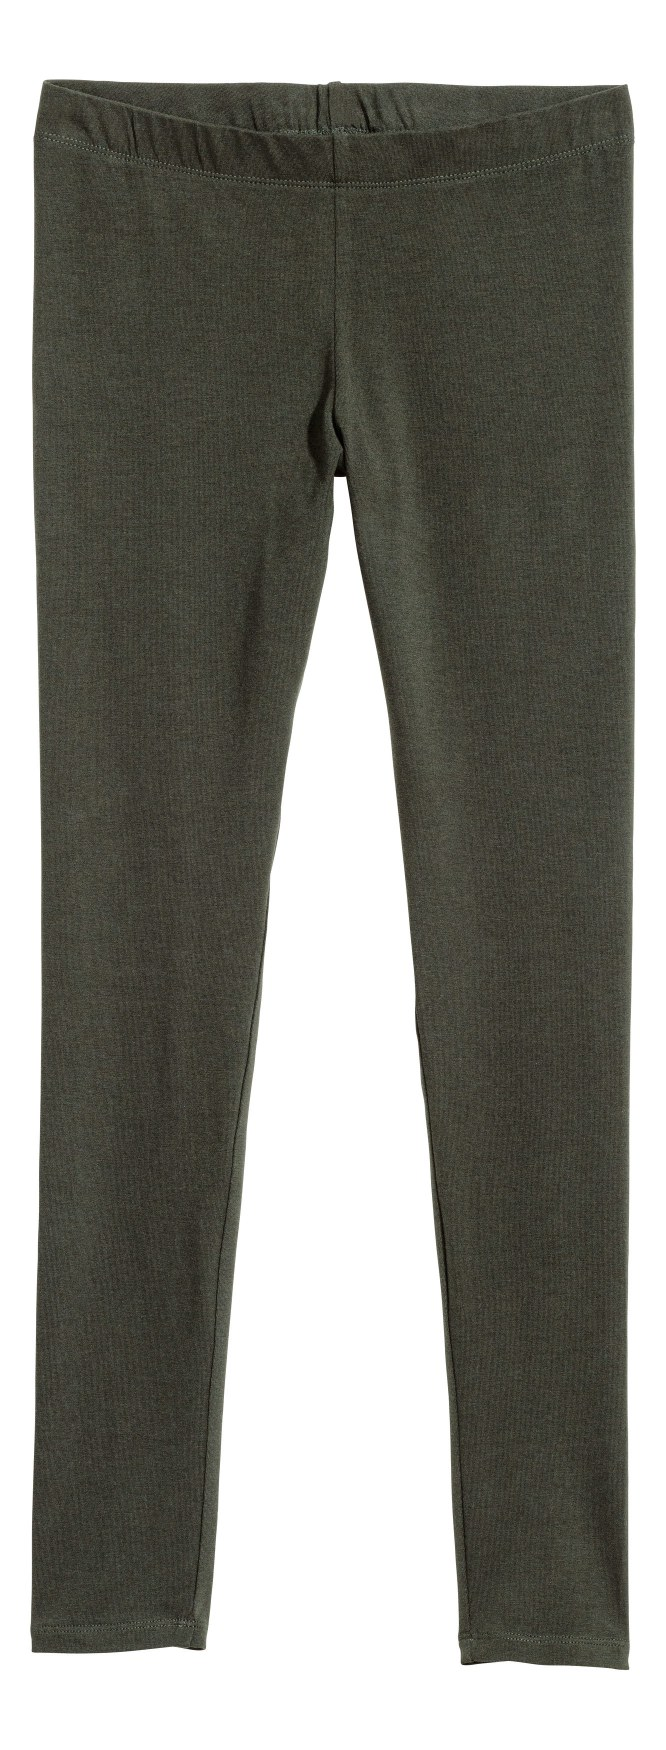

In [24]:
images = ["data_for_fashion_clip/189634031.jpg"]
corresponding_text = search_desc_by_image(images, image_embeddings, texts)
print(corresponding_text)
display(Image(images[0], width=300, height=200))

Mesurons la précision du classifieur en reprenant les images embeddings.

In [25]:
similarities = np.dot(image_embeddings, image_embeddings.T)
most_similar_indices = np.argmax(similarities, axis=0)

# Top-1 precision
top1_precision = np.mean(most_similar_indices == np.arange(len(image_embeddings)))
print(f"Top-1 precision: {top1_precision}")


# Top-5 precision 
five_most_similar_indices = np.argsort(similarities, axis=0)[-5:].T

top5_precision = np.mean([i in five_most_similar_indices[i] for i in range(len(image_embeddings))])
print(f"Top-5 precision: {top5_precision}")

Top-1 precision: 1.0
Top-5 precision: 1.0
